# setup

In [1]:
# plotting
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from matplotlib import pyplot as plt
from IPython.display import clear_output
from IPython.html.widgets import interact

plt.rcParams['figure.facecolor'] = (1, 1, 1)
plt.rcParams['axes.facecolor'] = (1, 1, 1)
plt.rcParams['xtick.direction'] = 'out'                                                                              
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Droid Sans']
plt.rcParams['figure.figsize'] = (12, 4)
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['xtick.major.size'] = 12
plt.rcParams['ytick.major.size'] = 12
plt.rcParams['figure.max_open_warning'] = 40
plt.rcParams['image.aspect'] = 'auto'
plt.rcParams['image.interpolation'] = 'nearest'

In [2]:
import glm
import simulation
from common import *

# 1D example

## source data

In [3]:
data = simulation.SimulatedData( N_sec=4 )

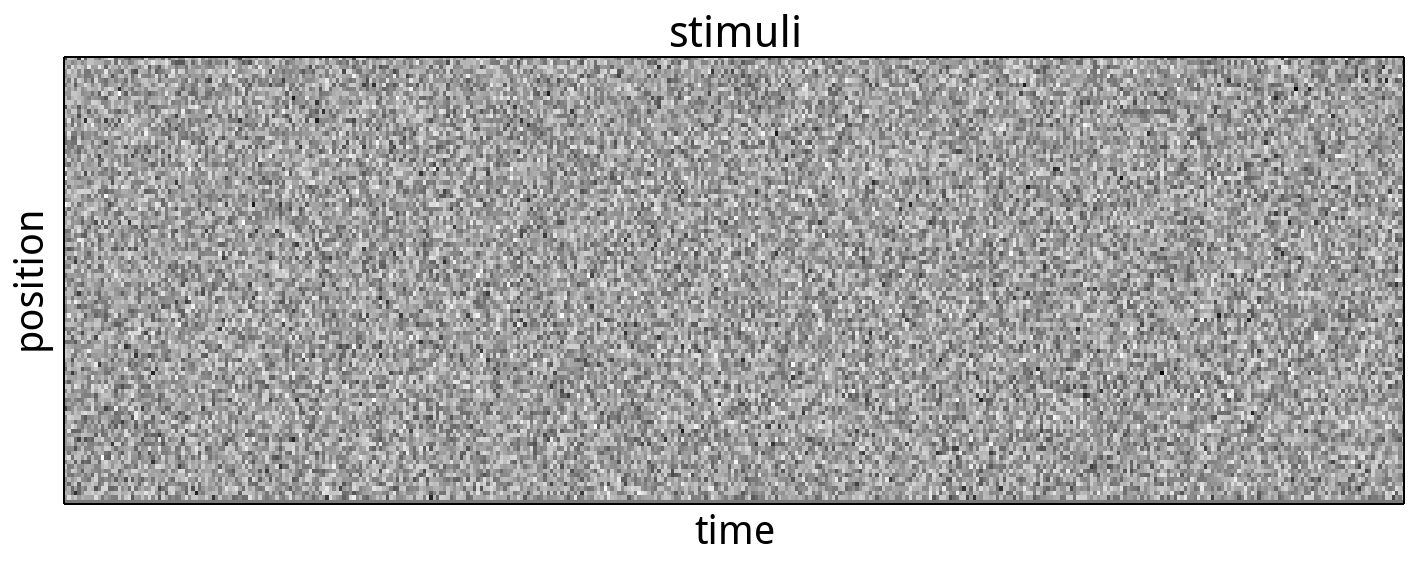

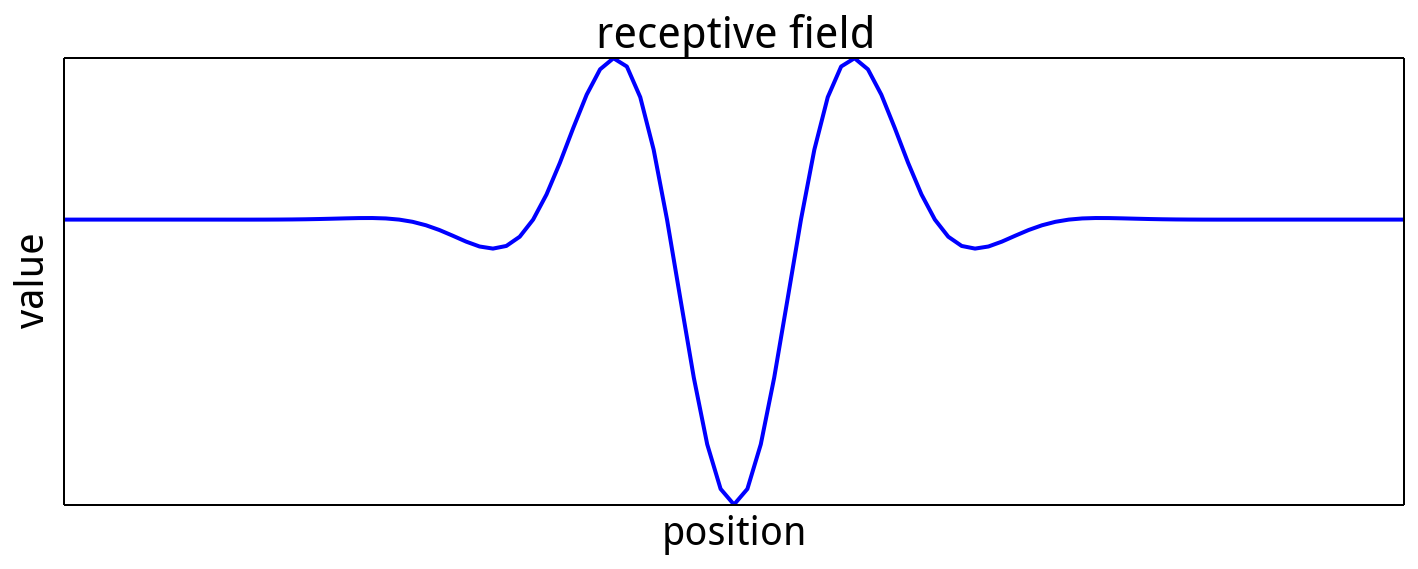

In [4]:
# plot stimuli
fig = plt.figure()
ax = fig.gca( xlabel='time', ylabel='position', xticks=[], yticks=[], title='stimuli' )
ax.imshow( data.X__td.T, cmap=plt.cm.Greys )

# plot receptive field
fig = plt.figure()
ax = fig.gca( xlabel='position', ylabel='value', xticks=[], yticks=[], title='receptive field' )
ax.plot( data.k_true, lw=2 )
pass

## solving

In [5]:
# maximum likelihood solution
ml = glm.ML( data, testing_proportion=0.2 )
ml.solve( verbose=False )

# ridge penalised solution
ridge = glm.Ridge( data, testing_proportion=0.2 )
ridge.training_slices = ml.training_slices
ridge.testing_slices = ml.testing_slices
ridge.solve( verbose=False )

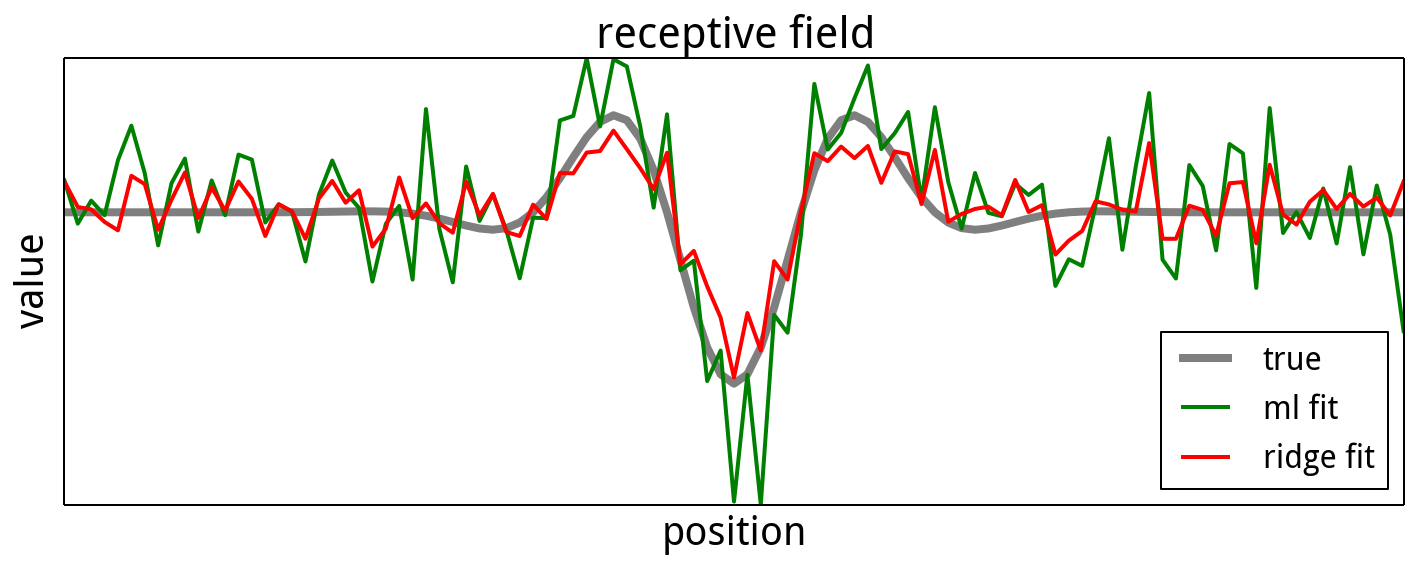

In [6]:
# plot receptive fields
fig = plt.figure()
ax = fig.gca( xlabel='position', ylabel='value', xticks=[], yticks=[], title='receptive field' )
ax.plot( data.k_true, lw=4, label='true', color='k', alpha=0.5 )
ax.plot( ml.k__d, color='g', lw=2, label='ml fit' )
ax.plot( ridge.k__d, color='r', lw=2, label='ridge fit' )
ax.legend( loc='lower right', fontsize=16 )
pass

In [7]:
# ML overfits to the training data, makes poorer predictions on the testing data
print 'training: %.3f' % (ridge.LL_training_per_observation - ml.LL_training_per_observation)
print 'testing:  %.3f' % (ridge.LL_testing_per_observation - ml.LL_testing_per_observation)

training: -0.069
testing:  0.460


# 2D example

## source data

In [8]:
# construct class
class SimulatedData2D( simulation.SimulatedData ):
    
    def make_k_true( self ):
        """ Generate stimulus-response relationship for simulation. """
        # dimensions
        self.D_x = D_x = 10
        self.D_y = D_y = 10
        self.D = D = D_x * D_y + 1 
        # create kernel
        i, j = np.meshgrid( np.arange(self.D_x), np.arange(self.D_y), indexing='ij' )
        k_true_2D = np.exp(-0.5 * ((j - 3) ** 2 + (i - 5) ** 2))
        k_true = np.concatenate([ k_true_2D.flatten(), [0] ])
        return k_true

In [9]:
# instantiate
data = SimulatedData2D( N_sec=4 )

## solving

In [10]:
# maximum likelihood solution
ml = glm.ML( data, testing_proportion=0.2 )
ml.solve( verbose=False )

# ridge penalised solution
ridge = glm.Ridge( data, testing_proportion=0.2 )
ridge.training_slices = ml.training_slices
ridge.testing_slices = ml.testing_slices
ridge.solve( verbose=False )

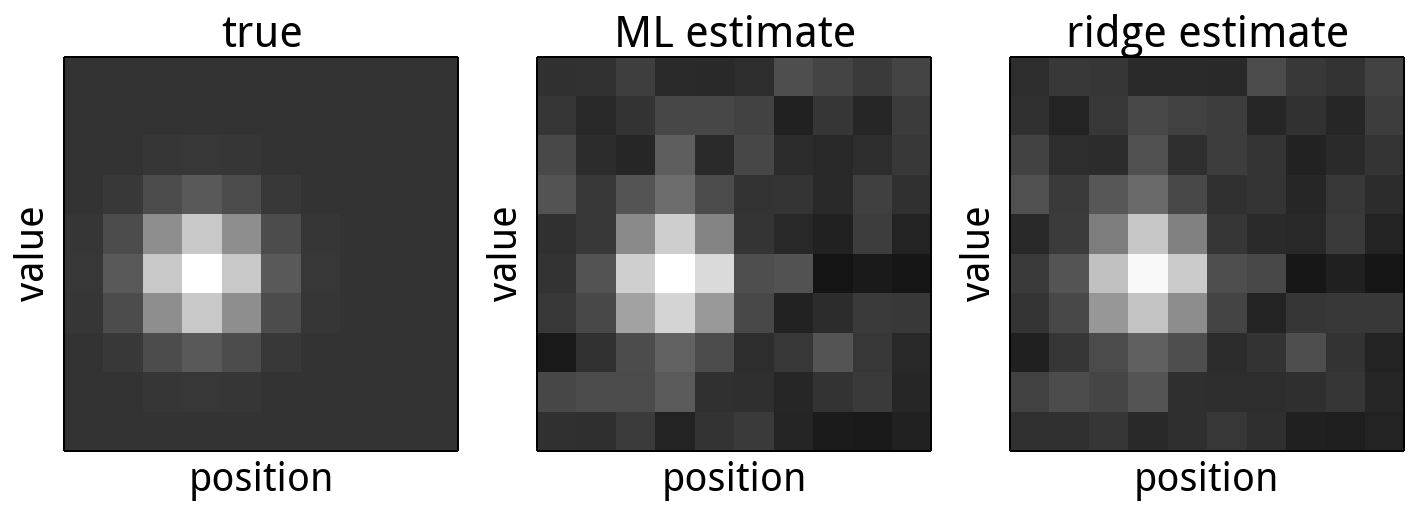

In [11]:
# plot receptive fields
fig = plt.figure()
ax = fig.add_subplot( 1, 3, 1, xlabel='position', ylabel='value', xticks=[], yticks=[], title='true' )
ax.imshow( data.k_true[:-1].reshape(10, 10), cmap=plt.cm.Greys_r, vmin=-0.2, vmax=1 )
ax.set_aspect('equal')

ax = fig.add_subplot( 1, 3, 2, xlabel='position', ylabel='value', xticks=[], yticks=[], title='ML estimate' )
ax.imshow( ml.k__d[:-1].reshape(10, 10), cmap=plt.cm.Greys_r, vmin=-0.2, vmax=1 )
ax.set_aspect('equal')

ax = fig.add_subplot( 1, 3, 3, xlabel='position', ylabel='value', xticks=[], yticks=[], title='ridge estimate' )
ax.imshow( ridge.k__d[:-1].reshape(10, 10), cmap=plt.cm.Greys_r, vmin=-0.2, vmax=1 )
ax.set_aspect('equal')

pass

In [12]:
# ML overfits to the training data, makes poorer predictions on the testing data
print 'training: %.3f' % (ridge.LL_training_per_observation - ml.LL_training_per_observation)
print 'testing:  %.3f' % (ridge.LL_testing_per_observation - ml.LL_testing_per_observation)

training: -0.016
testing:  0.370


# GLM with history dependence

## source data

In [70]:
class SimulatedData2DHistory( simulation.SimulatedData ):    

    def __init__( self, fs=100, N_sec=60, X_std=1, add_constant=True, nonlinearity='exp', **kw ):
        # save parameters
        self.fs = fs
        self.N_sec = N_sec
        self.T = np.floor( self.fs * self.N_sec )
        # create the kernel        
        self.k_stim = k_stim = self.make_k_stim_true()
        self.k_history = k_history = self.make_k_history_true()
        self.k_true = k_true = self.make_k_true()
        self.k_const = k_const = k_true[-1]
        # lengths
        self.D_stim = D_stim = len(k_stim)
        self.D_history = D_history = len(k_history)
        # stimulus driven firing rate
        X_stim = self.make_X_stim( X_std=X_std )
        z = dot( X_stim, k_stim )
        if nonlinearity == 'exp':
            mu = exp( z )
        elif nonlinearity == 'soft':
            mu = log( 1 + exp(z) ) / log(2)
        else:
            raise ValueError( 'unknown nonlinearity: %s' % nonlinearity )
        if add_constant:
            z += k_const
        # generate spikes (very inefficient)
        y = np.zeros_like(mu)
        for t in progress.dots(range(len(y)), 'sampling from generative model'):
            if t == 0:
                mu_history = 1.
            elif t <= self.D_history:
                prev_spikes = y[ : t-1 ]
                mu_history = exp( dot( prev_spikes, k_history[ : t-1 ] ) )
            else:
                prev_spikes = y[ t - self.D_history - 1 : t - 1 ][::-1]
                mu_history = exp(dot( prev_spikes, k_history ))
            y[t] = poisson( mu[t] * mu_history )
        # construct X
        X_history = np.zeros( (self.T, D_history) )
        for i in range( D_history ):
            X_history[ :, i  ] = np.roll( y, i+1 )
        X = np.hstack([ X_stim, X_history ])
        # continue initialising
        super( simulation.SimulatedData, self ).__init__( 
                X, y, add_constant=add_constant, **kw )

    def make_X_stim( self, X_std ):
        """ Generate stimulus matrix for simulation. """
        return normal( size = (self.T, self.D-1) ) * X_std
  
    def make_k_stim_true( self ):
        """ Generate stimulus-response relationship for simulation. """
        # dimensions
        self.D_x = D_x = 10
        self.D_y = D_y = 10
        self.D = D = D_x * D_y + 1 
        # create kernel
        i, j = np.meshgrid( np.arange(self.D_x), np.arange(self.D_y), indexing='ij' )
        k_true_2D = np.exp(-0.5 * ((j - 3) ** 2 + (i - 5) ** 2))
        k_true = k_true_2D.flatten()
        return k_true
    
    def make_k_history_true( self ):
        """ Generate history kernel for stimulation. """
        tt = np.arange(40.)
        k_history = -( np.sin(2 * np.pi * tt / (6 * np.sqrt(tt + 1))) * np.exp(-0.5 * (tt/12.)**2 ) ) * 0.01
        return k_history
    
    def make_k_const_true( self ):
        return A([0.5])
    
    def make_k_true( self ):
        """ Compile overall kernel. """
        return np.concatenate([ self.make_k_stim_true(), self.make_k_history_true(), self.make_k_const_true() ])

In [88]:
# instantiate
data = SimulatedData2DHistory( N_sec=10 )

sampling from generative model.....ooooo[0s]


## solving

In [89]:
# maximum likelihood solution
ml = glm.ML( data, testing_proportion=0.2 )
ml.solve( verbose=False )

# ridge penalised solution
ridge = glm.Ridge( data, testing_proportion=0.2 )
ridge.training_slices = ml.training_slices
ridge.testing_slices = ml.testing_slices
ridge.solve( verbose=False )

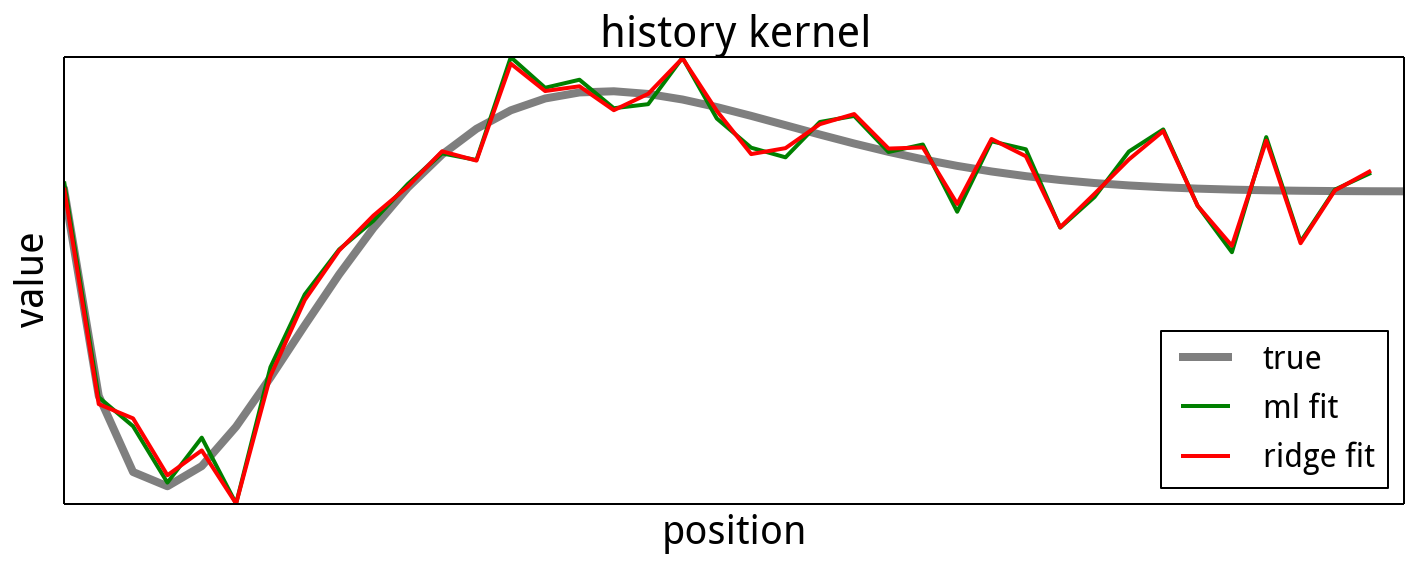

In [90]:
# plot history kernels
fig = plt.figure()
ax = fig.gca( xlabel='position', ylabel='value', xticks=[], yticks=[], title='history kernel' )
ax.plot( data.k_history, lw=4, label='true', color='k', alpha=0.5 )
ax.plot( ml.k__d[-40:-1], color='g', lw=2, label='ml fit' )
ax.plot( ridge.k__d[-40:-1], color='r', lw=2, label='ridge fit' )
ax.legend( loc='lower right', fontsize=16 )
pass

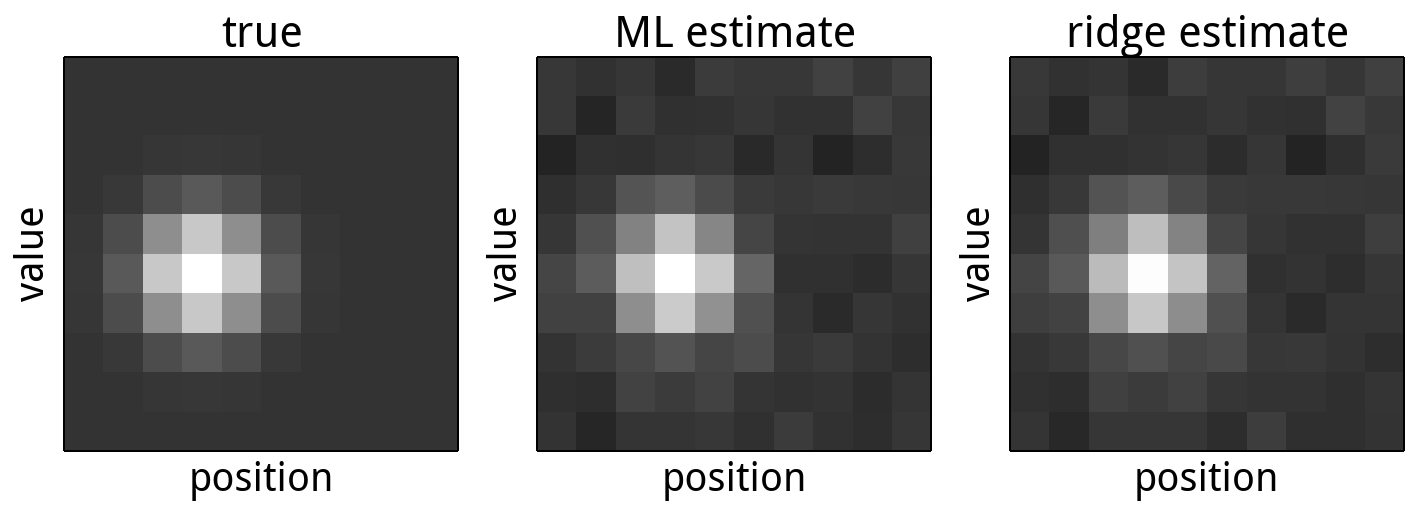

In [91]:
# plot receptive fields
fig = plt.figure()
ax = fig.add_subplot( 1, 3, 1, xlabel='position', ylabel='value', xticks=[], yticks=[], title='true' )
ax.imshow( data.k_true[:-41].reshape(10, 10), cmap=plt.cm.Greys_r, vmin=-0.2, vmax=1 )
ax.set_aspect('equal')

ax = fig.add_subplot( 1, 3, 2, xlabel='position', ylabel='value', xticks=[], yticks=[], title='ML estimate' )
ax.imshow( ml.k__d[:-41].reshape(10, 10), cmap=plt.cm.Greys_r, vmin=-0.2, vmax=1 )
ax.set_aspect('equal')

ax = fig.add_subplot( 1, 3, 3, xlabel='position', ylabel='value', xticks=[], yticks=[], title='ridge estimate' )
ax.imshow( ridge.k__d[:-41].reshape(10, 10), cmap=plt.cm.Greys_r, vmin=-0.2, vmax=1 )
ax.set_aspect('equal')

pass